In [40]:
import pickle
import networkx as nx
from itertools import combinations
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import itertools
with open('base_data/small2Graph1000.p', 'rb') as f:
    G = pickle.load(f)
with open('base_data/G_98-18_2.p', 'rb') as f :
    data = pickle.load(f)
for v,i in G.edges :
    try :
        G[v][i]['date'] = data[v][i]['date']
        G[v][i]['amount'] = data[v][i]['amount']
    except:
        print(v,i, "no_date")
        continue
THRESHOLD = 0.05

In [2]:
dates = []
for v,i in G.edges :
    try :
        dates.append(data[v][i]['date'])
    except:
        continue
divider = dict(zip(*np.unique(dates, return_counts=True)))
for v,i in G.edges :
    try :
        G[v][i]['corrected_amount'] = data[v][i]['amount']/(divider[data[v][i]['date']])
    except:
        print(v,i, "no_date")
        continue

# Illustrating Zheng's paper

In this notebook, I will illustrate Zheng's paper process to predict links.
Please note that I took a smaller graph so that it's easy to understand

In [3]:
years = []
years2 = []
unknown2 = 0
for v,i in data.edges():
    years.append(int(str(data[v][i]['date'])[:4]))
for v,i in G.edges():
    try :
        years2.append(int(str(G[v][i]['date'])[:4]))
    except:
        unknown2+=1
unique_years1 =  dict(zip(*np.unique(years, return_counts=True)))
unique_years2 = dict(zip(*np.unique(years2, return_counts=True)))
for year in range(1988, 2018):
    s = str(year) + "\t"
    try :
        s += str(unique_years1[year])+"\t"
    except:
        s+= "0\t"
    try :
        s += str(unique_years2[year])+"\t"
    except:
        s+= "0\t"
    print(s)



1988	4	0	
1989	2	0	
1990	3	0	
1991	4	0	
1992	1	0	
1993	4	0	
1994	8	0	
1995	10	0	
1996	33	0	
1997	96	0	
1998	282	0	
1999	1924	0	
2000	9292	0	
2001	3175	0	
2002	2581	0	
2003	2772	0	
2004	3405	1	
2005	4346	0	
2006	5401	3	
2007	7552	0	
2008	7425	1	
2009	7779	3	
2010	10733	2	
2011	14638	8	
2012	18410	24	
2013	24978	34	
2014	33131	49	
2015	38218	104	
2016	37623	10	
2017	36390	9	


/home/malaville/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


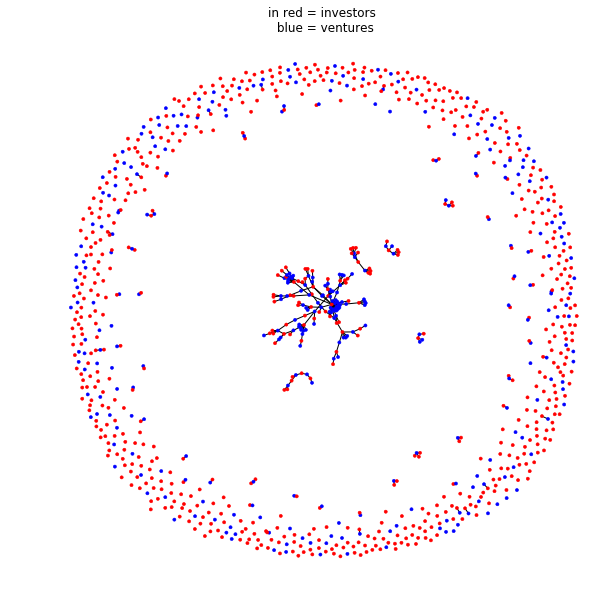

Number of nodes :  1000
Number of edges :  249
Number of investors :  670


In [4]:
plt.figure(figsize=(10,10))
plt.title("in red = investors \n blue = ventures")
colors = []
for node_name in list(G.nodes()) :
    if node_name[:4] == 'inv_':
        colors.append("r")
    else:
        colors.append("b")
    
nx.draw(G, node_size=10, pos=nx.spring_layout(G), node_color=colors, linewidths = 0.5)
plt.show()
print("Number of nodes : " ,len(G.nodes))
print("Number of edges : " , len(G.edges))
print("Number of investors : " , len([nod for nod in G.nodes if nod[:4]=='inv_']))

##### What does the biggest connected subgraph looks like ?

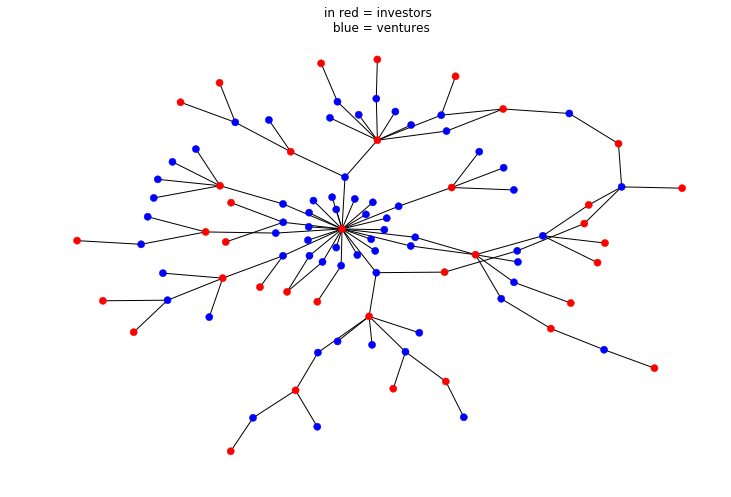

Number of nodes :  102
Number of edges :  106
Number of investors :  37


In [5]:
connected_components= nx.connected_component_subgraphs(G)
graphs = sorted(list(connected_components), key = lambda x : len(x.node))
G2 = graphs[-1]


plt.figure(figsize=(12,8))
plt.title("in red = investors \n blue = ventures")
colors = []
for node_name in list(G2.nodes()) :
    if node_name[:4] == 'inv_':
        colors.append("r")
    else:
        colors.append("b")
    
nx.draw(G2, node_size=50, pos=nx.kamada_kawai_layout(G2), node_color=colors, linewidths = 0.5)
plt.show()
print("Number of nodes : " ,len(G2.nodes))
print("Number of edges : " , len(G2.edges))
print("Number of investors : " , len([nod for nod in G2.nodes if nod[:4]=='inv_']))

# I -  DataCleaning of Zheng's

### Subset by timestamp and subgraph

We subset the Crunchbase data by taking advantage of the timestamps on each edge to create a network that includes all nodes that received or made an investment between 2005-2015. Due to the nature of the data collection, this preserved > 90% of the Crunchbase data on investments. To make this problem more tractable, we further restricted our analysis to the maximum weakly connected component of the graph (as observed in 2015) which consisted of ∼ 105k edges and ∼ 55k nodes (the next largest 
WCC has 20 nodes). In our network, there are ∼ 21k investors and ∼ 34k companies.


In [6]:
edges_05_15 = set([edge for edge in G.edges() if G[edge[0]][edge[1]] and str(G[edge[0]][edge[1]]['date'])[:4] in [str(x) for x in range(2005, 2016)]])
not_edges_05_15_or_with_no_dates = set(G.edges()) - edges_05_15
print(len(edges_05_15), " between 2005 and 2015 versus 249 before")
print(len(not_edges_05_15_or_with_no_dates), " deleted")

228  between 2005 and 2015 versus 249 before
21  deleted


In [7]:
#Here we remove the edges we no data from G, and we verify that G has the good number of edges
G.remove_edges_from(not_edges_05_15_or_with_no_dates)
print(len(G.edges()))
subgraphs = nx.connected_component_subgraphs(G)

228


In [8]:
subgraphslist = list(subgraphs)
number_of_subgraphs = len(subgraphslist)
sizes = [g.number_of_nodes() for g in subgraphslist]
mean_sizes = sum(sizes)/number_of_subgraphs
sizes2 = np.unique(sizes, return_counts=True)

print("Number of subgraphs :", number_of_subgraphs)
print("Mean size : ", mean_sizes)
print("Size \t Occurences")
for i in range(len(sizes2[0])):
    print(str(sizes2[0][i]) + "\t" + str(sizes2[1][i]))

Number of subgraphs : 776
Mean size :  1.288659793814433
Size 	 Occurences
1	716
2	40
3	9
4	3
5	4
8	1
10	1
33	1
94	1


### Observations :
The graph has a lot of connected subgraphs, but just 3 are above size 10, respectively 10, 33 and 94 nodes are located together. The largest connected component that you saw earlier **fell from 102 nodes to 94** because of some missing dates. Below you can see the largest component **before and after the date treatmen**.

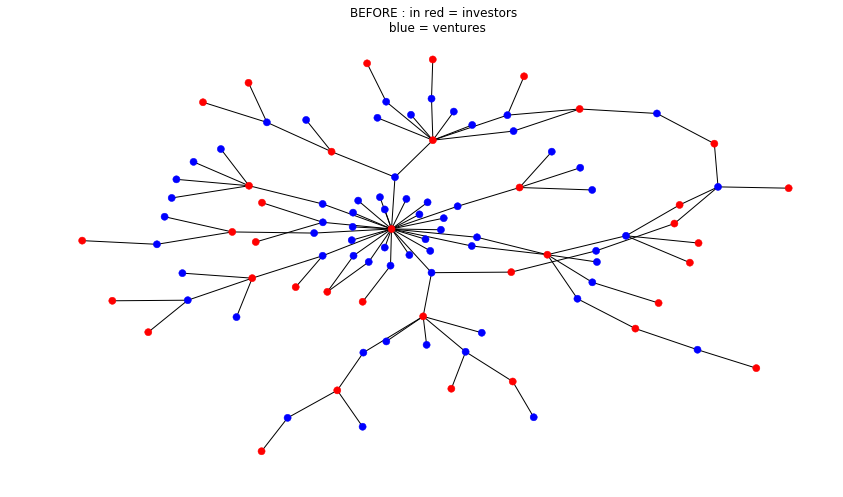

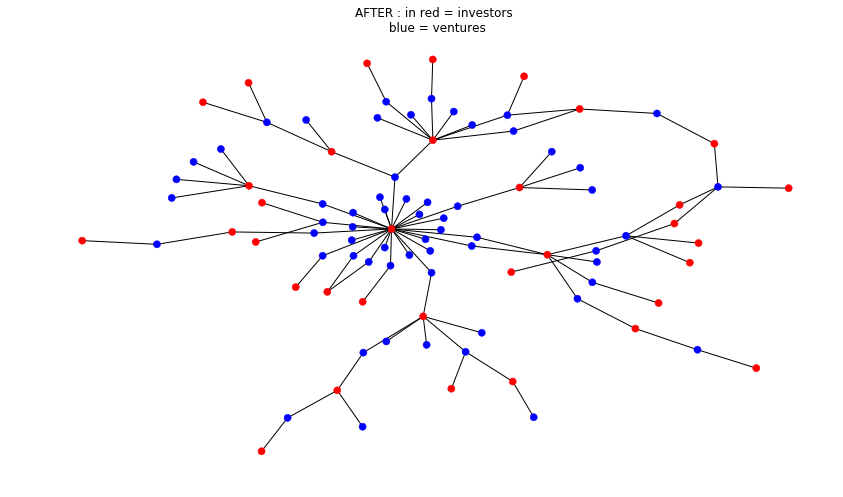

In [9]:
biggest_subgraph = sorted(subgraphslist, key = lambda x : len(x.nodes()))[-1]
pos=nx.kamada_kawai_layout(G2)
figsize=(14,8)

#Versus initial biggest
plt.figure(figsize=figsize)
plt.title("BEFORE : in red = investors \n blue = ventures")
colors = []
for node_name in list(G2.nodes()) :
    if node_name[:4] == 'inv_':
        colors.append("r")
    else:
        colors.append("b")
    
nx.draw(G2, node_size=50, pos=pos, node_color=colors, linewidths = 0.5)
plt.show()

#New Biggest
plt.figure(figsize=figsize)
plt.title("AFTER : in red = investors \n blue = ventures")
colors = []
for node_name in list(biggest_subgraph.nodes()) :
    if node_name[:4] == 'inv_':
        colors.append("r")
    else:
        colors.append("b")
    
nx.draw(biggest_subgraph, node_size=50, pos=pos, node_color=colors, linewidths = 0.5)
plt.show()

### Are there investor - investor or v - v relations ?
While the majority of our data adhered to the binary division between investor and startups, ∼ 400 nodes had both
received and given investments over our 10-year observation period. To enforce the bipartite property, we assigned
entities with strictly higher out-degree to the investor group
(and removed their incoming investment edges) and the
other companies to the start-up group (and removed their
outgoing investment edges). This simple heuristic preserves
the maximum number of edges and, by manual inspection,
seems to perform well in distinguishing the primary function of an entity.

In [10]:
investors = [inv for inv in G.nodes() if inv[:4]=='inv_']
ventures = [v for v in G.nodes() if v[:4] != 'inv_']
abnormal_inv_inv_links = []
abnormal_v_v_links = []
for inv1 in investors:
    for inv2 in investors :
        if inv2 in list(G[inv1]):
            print(inv1, inv2)
            abnormal_inv_inv_links.append((inv1,inv2))
for v1 in ventures:
    for v2 in ventures :
        if v2 in list(G[v1]):
            print(v1, v2)
            abnormal_v_v_links.append((v1,v2))

In [11]:
print("Nombre de liens anormaux INV_INV / V_V", len(abnormal_inv_inv_links), len(abnormal_v_v_links))

Nombre de liens anormaux INV_INV / V_V 0 0


### Observations :
Here there seem to be no invalid links. Zheng was working we some data where investors received some funds, and vis-versa, some ventures were investing.

### Working on the new subgraph 2005 - 2015
#### Making 3months snapshots

In [12]:
G3 = biggest_subgraph
del G
del G2
del biggest_subgraph

In [13]:
selectors = {}
for year in range(2005, 2016):
    selectors[year] = {}
    for trimestre in [1,2,3,4] :
        mois = [3*(trimestre-1) + x for x in [1,2,3]]
        selectors[year][trimestre] = [(year, moi) for moi in mois]
        
def selectors_list(from_y_t, to_y_t) :
    list_of_matching_year_month = []
    if from_y_t[0] == to_y_t[0]:
        for trimester in range(from_y_t[1], to_y_t[1] +1) :
            list_of_matching_year_month+=(selectors[from_y_t[0]][trimester])
        return list_of_matching_year_month
    else :
        for year in range(from_y_t[0], to_y_t[0] +1):
            if year == from_y_t[0] :
                for trimester in range(from_y_t[1], 5):
                    list_of_matching_year_month+=(selectors[year][trimester])
            elif year == to_y_t[0] :
                for trimester in range(1, to_y_t[1]+1) :
                    list_of_matching_year_month+=(selectors[year][trimester])
            else:
                for trimester in range(1,5):
                    list_of_matching_year_month+=(selectors[year][trimester])
        return list_of_matching_year_month

def edges_with_year_trimester(G, from_y_t, to_y_t):
    yt_list = selectors_list(from_y_t, to_y_t)
    edges_corresponding = set([edge for edge in G.edges() if G[edge[0]][edge[1]] and (int(str(G[edge[0]][edge[1]]['date'])[:4]) , int(str(G[edge[0]][edge[1]]['date'])[5:7])) in yt_list])
    return(edges_corresponding)

In [14]:
already_seen = []
for i,v in list(edges_with_year_trimester(G3, (2005,1), (2015,4))):
    if (i,v) in already_seen or (v,i) in already_seen:
        print(i,v)
    else :
        already_seen.append((i,v))

In [15]:
pos=nx.kamada_kawai_layout(G3)
figsize=(14,5)
showingFig = False
stopping_at = 70
for y in range(2005,2016):
    for t in range(1,5):
        edgesLocal = edges_with_year_trimester(G3, (2005,1), (y, t))
        #print("from 2005 to {0} - {1}th trimester number of edges : ".format(y,t), len(edgesLocal), 100*len(edgesLocal)/len(G3.edges))
        
        Glocal = nx.Graph()
        Glocal.add_edges_from(edgesLocal)
        if 100*len(edgesLocal)/len(G3.edges) < 70 :
            G70 = Glocal
        if 100*len(edgesLocal)/len(G3.edges) < 101 :
            G100 = Glocal
        if showingFig :
            plt.figure(figsize=figsize)
            plt.xlim([-1,1])
            plt.ylim([-1,1])
            plt.title("from 2005 to {0} - {1}th trimester".format(y,t))
            colors = []
            for node_name in list(Glocal.nodes()) :
                if node_name[:4] == 'inv_':
                    colors.append("r")
                else:
                    colors.append("b")

            nx.draw(Glocal, node_size=50, pos=pos, node_color=colors, linewidths = 0.5)
            plt.savefig("output_data/growing_subgraph_{0}_{1}_bla.png".format(y,t))

↑ Erase the # if you want to create the images that were used to create this animated image.
#### This represents the graph while iterating through trimesters
<img style="border:solid 1px rgb(240,240,240); margin-top:20px; width: 80%;" src="content/gifexample_data.gif">

### 70%  vs 100% graph
Below I show you the graphs with 70% and 100% of edges, we will use this for training.
<img style="margin-top:20px; width: 80%;" src="content/gif70_100.gif">

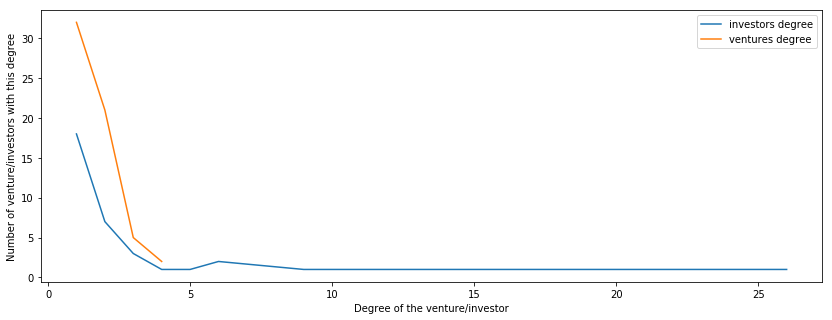

In [16]:
investors = set([(nod) for nod in G3.nodes if nod[:4]=='inv_'])
investor_degrees = [ G3.degree(nod) for nod in investors]
ventures = set(G3.nodes)-investors
ventures_degrees = [G3.degree(nod) for nod in ventures]
X,Y = np.unique(investor_degrees, return_counts=True)
X2,Y2 = np.unique(ventures_degrees,return_counts=True)
plt.figure(figsize=figsize)
plt.plot(X,Y,label='investors degree')
plt.plot(X2,Y2, label='ventures degree')
plt.xlabel("Degree of the venture/investor")
plt.ylabel("Number of venture/investors with this degree")
plt.legend()
plt.show()

# II - Scores used by Zheng's

### 0 - Candidates edges

In [17]:
def put_inv_on_right(set_of_links):
    S = set()
    for v,i in set_of_links:
        if v[:4]=='inv_':
            S.add((i,v))
        else :
            S.add((v,i))
    return S

ventures = [nod for nod in G70.nodes if nod[:4] != 'inv_']
investors = [nod for nod in G70.nodes if nod[:4] == 'inv_']
possible_edges = []
for i in investors:
    possible_edges += [(v,i) for v in ventures]

    
possible_edges=set(possible_edges)
existing_edges = set(put_inv_on_right(G70.edges()))
target_edges = set(put_inv_on_right(G100.edges())) - existing_edges
candidate_edges = possible_edges - existing_edges

pickle.dump(possible_edges, open('output_data/possible_edges_small.p','wb'))
pickle.dump(existing_edges, open('output_data/existing_edges_small.p','wb'))
pickle.dump(target_edges, open('output_data/target_edges_small.p','wb'))
pickle.dump(candidate_edges, open('output_data/candidate_edges_small.p','wb'))

print("There are {0} possible edges of which {1} are already existing in period 1".format(len(possible_edges), len(existing_edges)))
print("So there are {0} edges left candidate of which only {1} we really want".format(len(candidate_edges), len(target_edges)))

CalcG = nx.Graph()
CalcG.add_edges_from(possible_edges)
for v,i in possible_edges :
    CalcG[v][i]['type'] = "P"
    CalcG[v][i]['score'] = {}
for v,i in existing_edges :
    CalcG[v][i]['type'] = "E"
for v,i in candidate_edges :
    CalcG[v][i]['type'] = "C"

types = []
for v,i in CalcG.edges():
    types.append(CalcG[v][i]['type'])
print(np.unique(types, return_counts=True))

There are 1008 possible edges of which 65 are already existing in period 1
So there are 943 edges left candidate of which only 32 we really want
(array(['C', 'E'], dtype='<U1'), array([943,  65]))


### 1 - Random
$score_{random}(i,c) \rightarrow Unif(0,1)$

In [18]:
for v,i in candidate_edges :
    CalcG[v][i]['score']['random'] = random.random()

In [19]:
edges_color = []
edges_label = []
for v,i in CalcG.edges:
    edges_color.append(CalcG[v][i]['score']['random'] if CalcG[v][i]['type'] == "C" else 1.2)

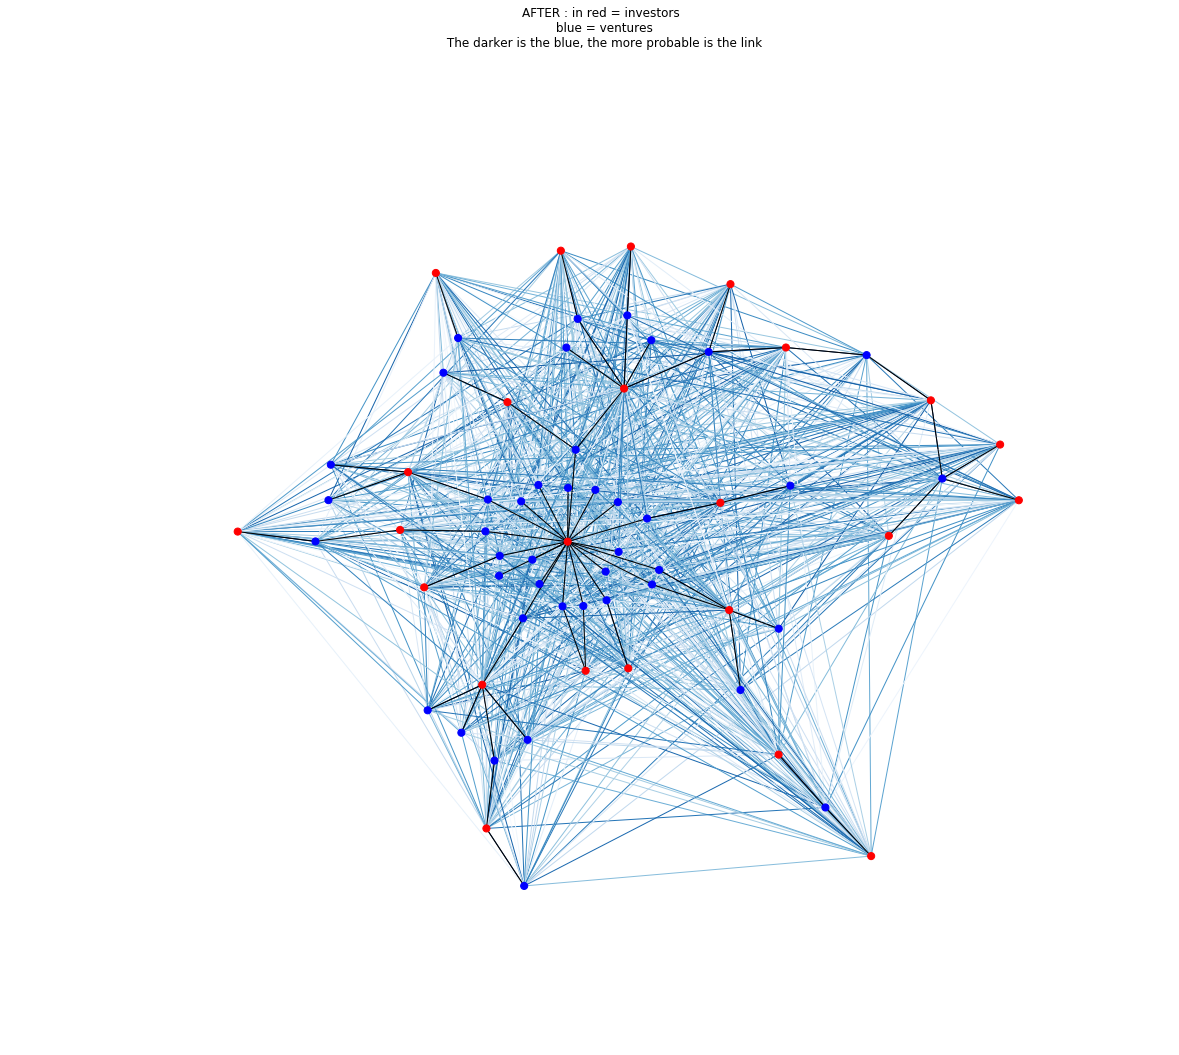

In [20]:
pos=nx.kamada_kawai_layout(G3)
figsize=(20,18)

plt.figure(figsize=figsize)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title("AFTER : in red = investors \n blue = ventures\n The darker is the blue, the more probable is the link")
colors = []
for node_name in list(CalcG.nodes()) :
    if node_name[:4] == 'inv_':
        colors.append("r")
    else:
        colors.append("b")
nx.draw(CalcG, node_size=50, pos=pos, node_color=colors, linewidths = 1, edge_color=edges_color, edge_cmap=plt.cm.Blues)
nx.drawing.nx_pylab.draw_networkx_edges(CalcG, pos=pos, edgelist=existing_edges)
plt.show()

### 2 - Preferential Attachment

$score_{P_A}(v,i) = \frac{|\Gamma(v)||\Gamma(i)|}{z}$ where $\Gamma(i)$ est égale au degré (nombre de liens) du noeud considéré dans le graphe à 70%. J'ai choisi $z = max(|\Gamma(v)||\Gamma(i)|)$

Un exemple est présenté un peu plus bas.

In [21]:
maxi_pref = 0
for v,i in candidate_edges :
    CalcG[v][i]['score']['pref'] = G70.degree(v)*G70.degree(i)
    if CalcG[v][i]['score']['pref'] > maxi_pref:
        maxi_pref = CalcG[v][i]['score']['pref']
print(maxi_pref)
for v,i in candidate_edges :
    CalcG[v][i]['score']['pref'] /= maxi_pref

84


In [22]:
edges_color = []
edges_label = []
edges_thresholded = []
for v,i in CalcG.edges:
    if CalcG[v][i]['type'] == "C" and CalcG[v][i]['score']['pref'] > THRESHOLD :
        edges_thresholded.append((v,i))
        edges_color.append(CalcG[v][i]['score']['pref'])

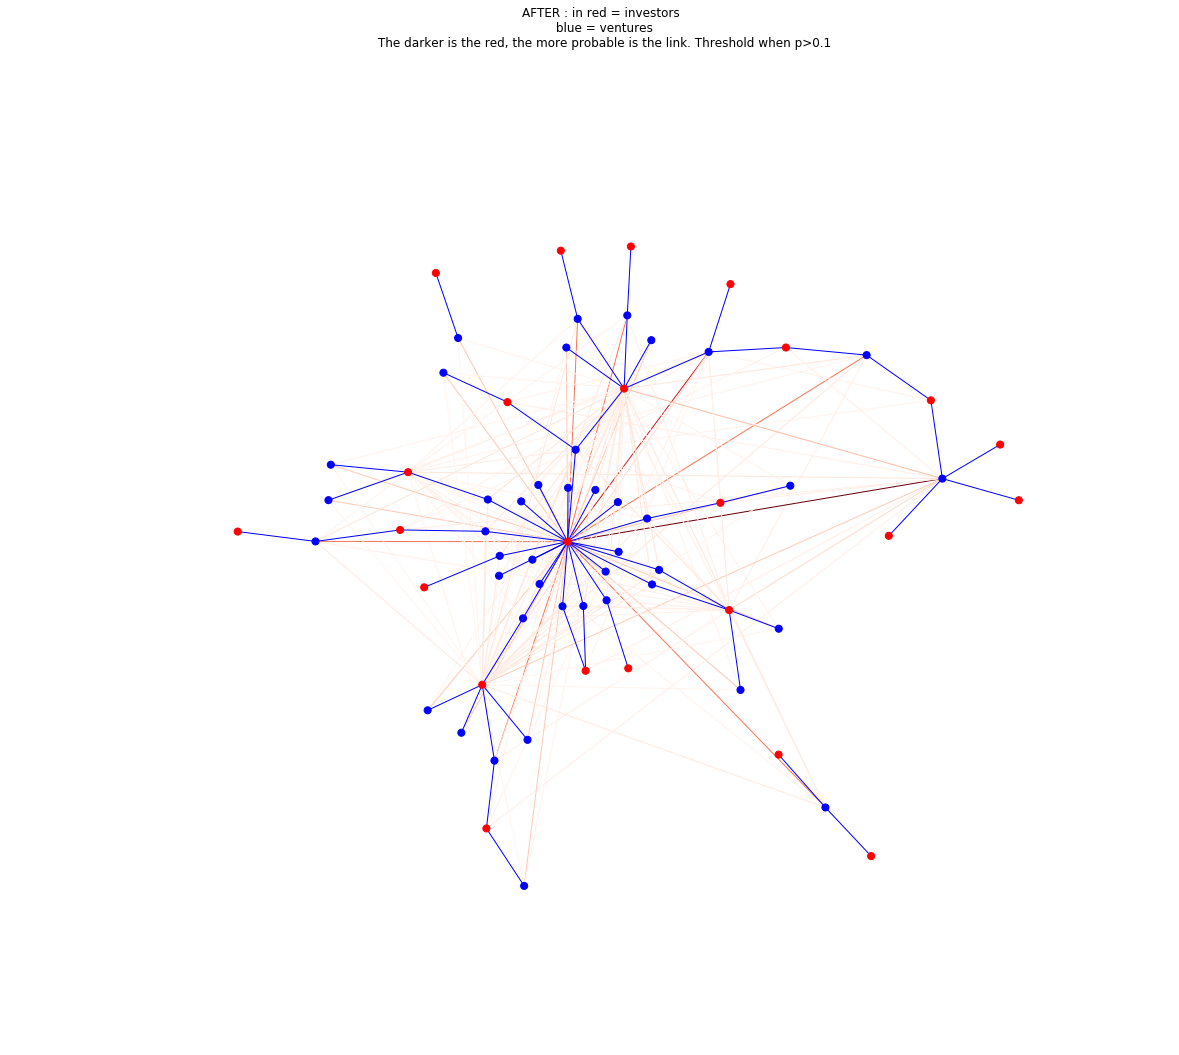

Nous allons illustrer pour le score maximal
v:  mytime  		Gamma(v) = 4
i:  inv_y-combinator  	Gamma(i) = 21
Donc score_pref(v,i) =  84 / 84  = 1 en rouge foncé sur le graphe ci-dessus


In [23]:
pos=nx.kamada_kawai_layout(G3)
figsize=(20,18)

plt.figure(figsize=figsize)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title("AFTER : in red = investors \n blue = ventures\n The darker is the red, the more probable is the link. Threshold when p>0.1")
colors = []
for node_name in list(CalcG.nodes()) :
    if node_name[:4] == 'inv_':
        colors.append("r")
    else:
        colors.append("b")
nx.draw(CalcG, node_size=50, pos=pos, node_color=colors, linewidths = 1, edge_color=edges_color, edge_cmap=plt.cm.Reds, edgelist=edges_thresholded)
nx.drawing.nx_pylab.draw_networkx_edges(CalcG, pos=pos, edgelist=existing_edges, edge_color="b")
plt.show()

for v,i in candidate_edges:
    if CalcG[v][i]['score']['pref'] == 1 :
        print("Nous allons illustrer pour le score maximal")
        print("v: ", v, " \t\tGamma(v) =" , G70.degree(v) )
        print("i: ", i, " \tGamma(i) =" , G70.degree(i) )
        print("Donc score_pref(v,i) = ", G70.degree(i)*G70.degree(v) , "/" , maxi_pref, " = 1 en rouge foncé sur le graphe ci-dessus")

### 3 - Weighted Preferential Attachment

Idée pour moi : Essayer de faire un $\rho(i) = \sum_{l_{lien}}\frac{1}{age-du-lien}$

$score_{WP_A}(v,i) = \frac{|\rho(v)||\rho(i)|}{z}$ where $\rho(i)$ est égale à la somme des poids des liens du noeud, ici on devrait prendre les investissements. 

J'ai choisi $z = max(|\rho(v)||\rho(i)|)$

On peut discuter cette approche probablement.

### 4 - Segmented preferential attachement

$C_v$ is the *cluster of v*. The clusters need to be defined in each case. Zheng made 3 clusters, in the (degree, sumInvests) space. Therefore the highly connected and highly wealthy investors, were interested in highly connected ventures which received high amounts of money

$$
score_{SP_A}(v,i) = \left\{
    \begin{array}{ll}
        \frac{|\rho(v)||\rho(i)|}{z} & \mbox{si } C_v = C_i \\
        0 & \mbox{sinon}
    \end{array}
\right.
$$

#### 4.1 Segmentation - *Clustering* - Degree/MND

Considering the fact that I don't have amounts invested yet, I propose to cluster with the two measures :
* degree of the node
* mean degree of the nodes it's connected to

This idea is interesting considering the fact that some investors are interested in ventures which received more investments (late stage) and some investors are more early stage.


In [24]:
dict_of_MND = {}
for nod in G70.nodes:
    sum_of_degrees= 0
    n_neigh = G70.degree(nod)
    for neigh in G70.neighbors(nod) :
        sum_of_degrees+= G70.degree(neigh)
    dict_of_MND[nod] = sum_of_degrees/n_neigh

nx.set_node_attributes(CalcG, dict_of_MND, 'MND')

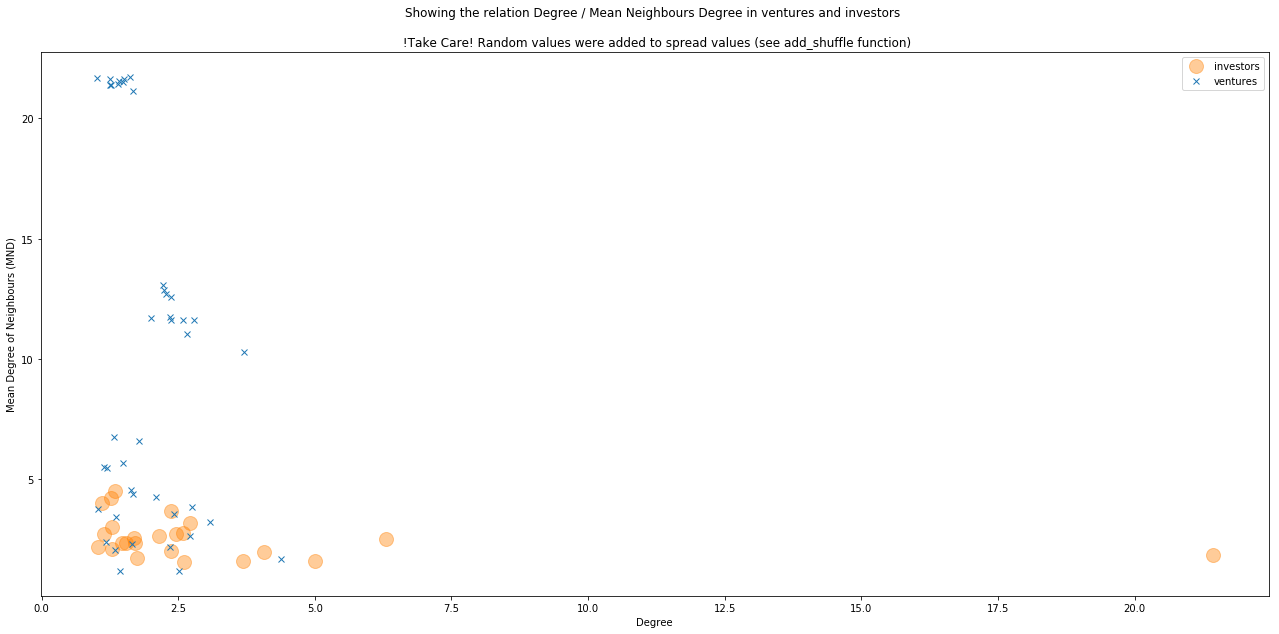

In [25]:
Dinv, Dv, MNDinv, MNDv, Gnodes = [],[],[],[],[]
def add_shuffle(X,size):
    newX = []
    for x in X:
        newX.append(x + size*random.random())
    return newX

for nod in G70.nodes :
    Gnodes.append(nod)
    if nod[:4] == 'inv_' :
        Dinv.append(G70.degree(nod))
        MNDinv.append(CalcG.nodes()[nod]['MND'])
    else :
        Dv.append(G70.degree(nod))
        MNDv.append(CalcG.nodes()[nod]['MND'])

shuffle_size = 0.8
plt.figure(figsize=(22,10))
plt.plot(add_shuffle(Dinv,shuffle_size),add_shuffle(MNDinv,shuffle_size), 'o', label='investors', color=(1,0.5,0,0.4),markersize=14)
plt.plot(add_shuffle(Dv,shuffle_size), add_shuffle(MNDv,shuffle_size), 'x', label='ventures')
plt.title("Showing the relation Degree / Mean Neighbours Degree in ventures and investors \n\n !Take Care! Random values were added to spread values (see add_shuffle function)")
plt.xlabel("Degree")
plt.ylabel("Mean Degree of Neighbours (MND)")
plt.legend()
plt.show()

In [26]:
km = KMeans(n_clusters=3)
D_MND = list(zip(Dinv+Dv,MNDinv+MNDv))
clusters = km.fit_predict(D_MND)

No handles with labels found to put in legend.


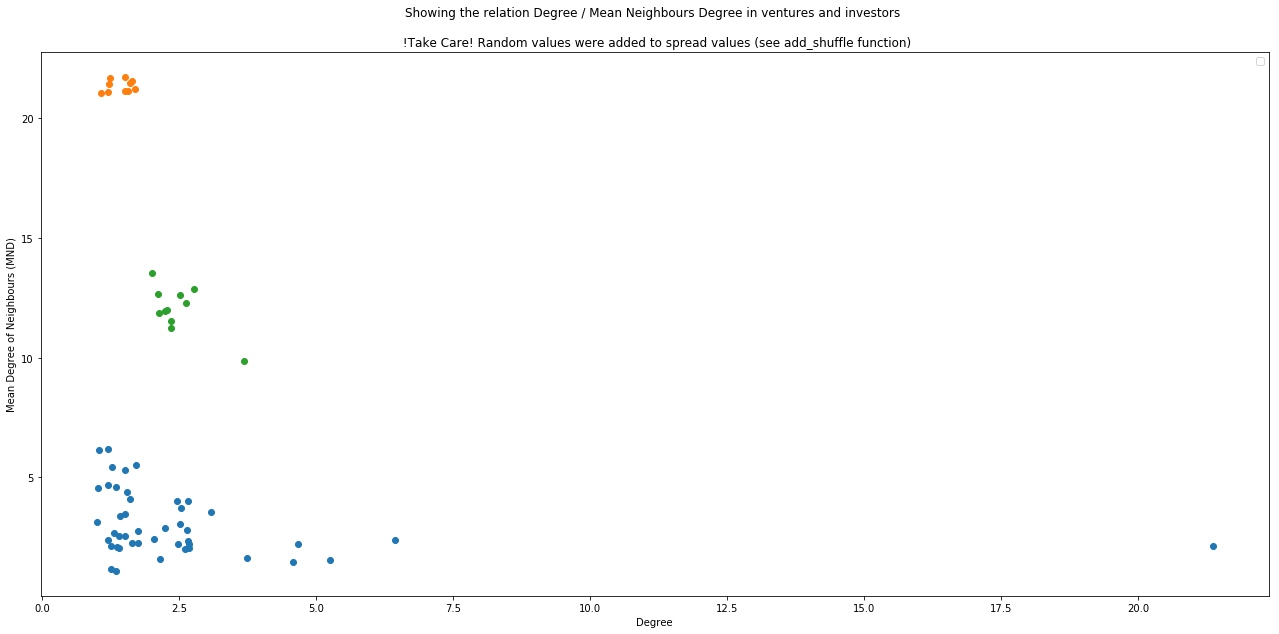

In [27]:
clusteredX = [[],[],[]]
clusteredY = [[],[],[]]
for i in range(3):
    for j in range(len(Gnodes)):
        if clusters[j] == i :
            clusteredX[i].append((Dinv+Dv)[j])
            clusteredY[i].append((MNDinv+MNDv)[j])
            
plt.figure(figsize=(22,10))
plt.plot(add_shuffle(clusteredX[0],shuffle_size),add_shuffle(clusteredY[0],shuffle_size), 'o')
plt.plot(add_shuffle(clusteredX[1],shuffle_size),add_shuffle(clusteredY[1],shuffle_size), 'o')
plt.plot(add_shuffle(clusteredX[2],shuffle_size),add_shuffle(clusteredY[2],shuffle_size), 'o')

plt.title("Showing the relation Degree / Mean Neighbours Degree in ventures and investors \n\n !Take Care! Random values were added to spread values (see add_shuffle function)")
plt.xlabel("Degree")
plt.ylabel("Mean Degree of Neighbours (MND)")
plt.legend()
plt.show()

##### Problem

In our case, the two smallest clusters are pure ventures, so it's impossible to create links among them.

##### Let's try clustering ventures and investors

No handles with labels found to put in legend.


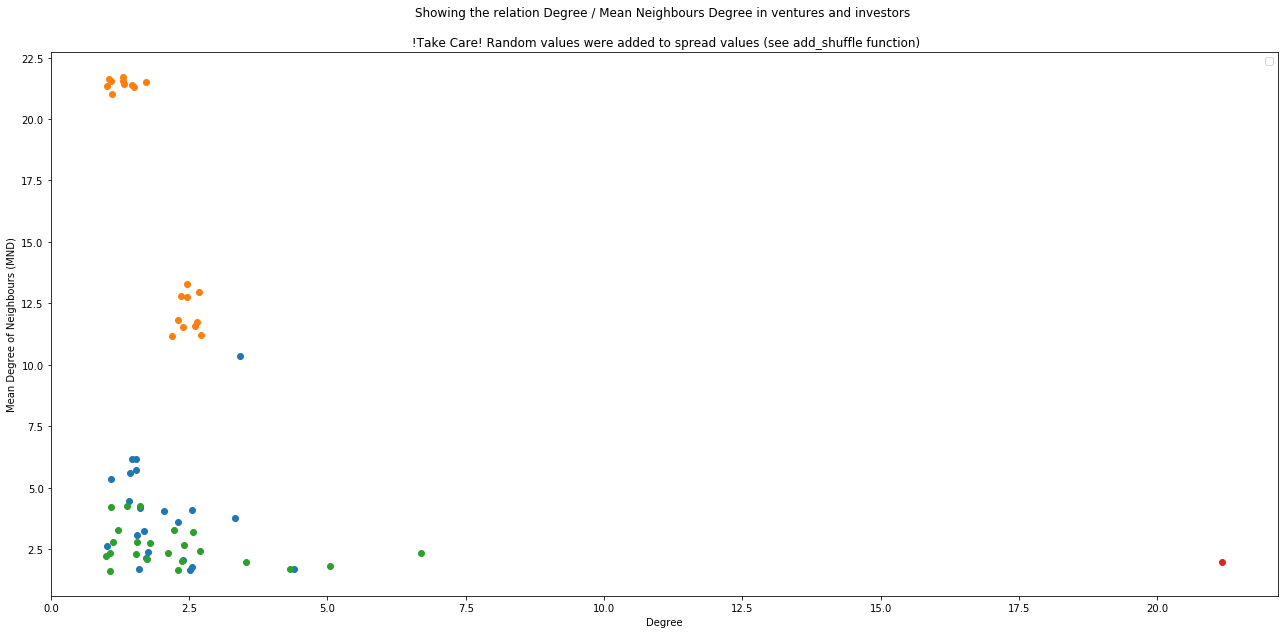

In [28]:
km_inv = KMeans(n_clusters=2)
D_MND_inv = list(zip(Dinv,MNDinv))
clusters_inv = km_inv.fit_predict(D_MND_inv)

km_v = KMeans(n_clusters=2)
D_MND_v = list(zip(Dv,MNDv))
clusters_v = km_v.fit_predict(D_MND_v)

clusteredXv = [[],[]]
clusteredYv = [[],[]]
clusteredXinv =  [[],[]]
clusteredYinv =  [[],[]]
for i in range(2):
    for j in range(len(Dv)):
        if clusters_v[j] == i :
            clusteredXv[i].append((Dv)[j])
            clusteredYv[i].append((MNDv)[j])
            
for i in range(2):
    for j in range(len(Dinv)):
        if clusters_inv[j] == i :
            clusteredXinv[i].append((Dinv)[j])
            clusteredYinv[i].append((MNDinv)[j])
            
plt.figure(figsize=(22,10))
plt.plot(add_shuffle(clusteredXv[0],shuffle_size),add_shuffle(clusteredYv[0],shuffle_size), 'o')
plt.plot(add_shuffle(clusteredXv[1],shuffle_size),add_shuffle(clusteredYv[1],shuffle_size), 'o')
plt.plot(add_shuffle(clusteredXinv[0],shuffle_size),add_shuffle(clusteredYinv[0],shuffle_size), 'o')
plt.plot(add_shuffle(clusteredXinv[1],shuffle_size),add_shuffle(clusteredYinv[1],shuffle_size), 'o')

plt.title("Showing the relation Degree / Mean Neighbours Degree in ventures and investors \n\n !Take Care! Random values were added to spread values (see add_shuffle function)")
plt.xlabel("Degree")
plt.ylabel("Mean Degree of Neighbours (MND)")
plt.legend()
plt.show()

In [29]:
types_of_link = []
for v,i in G70.edges:
    CalcG[v][i]['clusterA_clusterB'] = (km_v.predict([(G70.degree(v), CalcG.nodes()[v]['MND'])])[0],km_inv.predict([(G70.degree(i), CalcG.nodes()[i]['MND'])])[0])
    types_of_link.append(str(CalcG[v][i]['clusterA_clusterB']))
np.unique(types_of_link, return_counts=True)

(array(['(0, 0)', '(1, 0)', '(1, 1)'], dtype='<U6'), array([58,  6,  1]))

##### Matching clusters

Here we're matching cluster maximizing the 'tendency to link' between clusters before. That is to say we are looking for the permutation $\sigma$ of {0,1} that maximizes the links between those clusters.

Zheng's matches cluster taking the farthest centroid from (0,0) for investors matching it with farthest centroid for ventures, then iterating until no cluster is left.

We can see that :
* Cv0 is linked 7 times to Cinv0  and Cv0 is linked 1 time with Cinv1
* Cv1 is linked 57 times to Cinv0 and 0 times to Cinv1

Therefore, the couples of clusters that maximize the sum of links  are (Cv1 - Cinv0) = 57 links and (Cv0 - Cinv1 ) =  1link

In [30]:
cluster_dict = {}
for v,i in candidate_edges:
    Cv, Cinv = (km_v.predict([(G70.degree(v), CalcG.nodes()[v]['MND'])])[0],km_inv.predict([(G70.degree(i), CalcG.nodes()[i]['MND'])])[0])
    if (Cv,Cinv) in [(1,0), (0,1)]:
        CalcG[v][i]['compatible'] = True
        cluster_dict[v] = 'Cv_'+str(Cv)
        cluster_dict[i] = 'Cinv_'+str(Cinv)
    else :
        CalcG[v][i]['compatible'] = False
        cluster_dict[v] = 'Cv_'+str(Cv)
        cluster_dict[i] = 'Cinv_'+str(Cinv)

### 4.1 Segmentation - *Clustering* - Degree/MeanAmountsInvested (MAI)



In [31]:
dict_of_MAI = {}
for nod in G70.nodes:
    sum_of_AI= 0
    n_neigh = G70.degree(nod)
    for neigh in G70.neighbors(nod) :
        sum_of_AI+= G3[nod][neigh]['corrected_amount']
    dict_of_MAI[nod] = sum_of_AI/n_neigh

nx.set_node_attributes(CalcG, dict_of_MAI, 'MAI')

In [32]:
Dinv, Dv, MAIinv, MAIv, Gnodes = [],[],[],[],[]

for nod in G70.nodes :
    Gnodes.append(nod)
    if nod[:4] == 'inv_' :
        Dinv.append(G70.degree(nod))
        MAIinv.append(CalcG.nodes()[nod]['MAI'])
    else :
        Dv.append(G70.degree(nod))
        MAIv.append(CalcG.nodes()[nod]['MAI'])

No handles with labels found to put in legend.


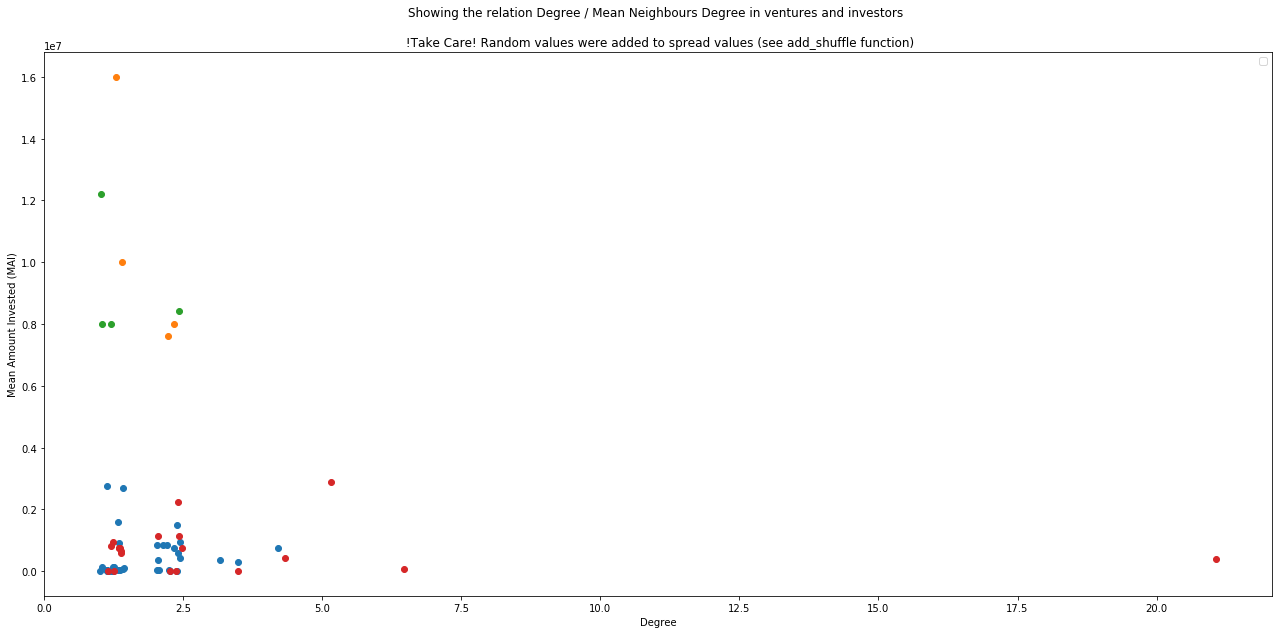

In [33]:
km_inv2 = KMeans(n_clusters=2)
D_MAI_inv = list(zip(Dinv,MAIinv))
clusters_inv = km_inv2.fit_predict(D_MAI_inv)

km_v2 = KMeans(n_clusters=2)
D_MAI_v = list(zip(Dv,MAIv))
clusters_v = km_v2.fit_predict(D_MAI_v)

clusteredXv = [[],[]]
clusteredYv = [[],[]]
clusteredXinv =  [[],[]]
clusteredYinv =  [[],[]]
for i in range(2):
    for j in range(len(Dv)):
        if clusters_v[j] == i :
            clusteredXv[i].append((Dv)[j])
            clusteredYv[i].append((MAIv)[j])
            
for i in range(2):
    for j in range(len(Dinv)):
        if clusters_inv[j] == i :
            clusteredXinv[i].append((Dinv)[j])
            clusteredYinv[i].append((MAIinv)[j])
            
plt.figure(figsize=(22,10))
shuffle_size=0.5
plt.plot(add_shuffle(clusteredXv[0],shuffle_size),add_shuffle(clusteredYv[0],shuffle_size), 'o')
plt.plot(add_shuffle(clusteredXv[1],shuffle_size),add_shuffle(clusteredYv[1],shuffle_size), 'o')
plt.plot(add_shuffle(clusteredXinv[0],shuffle_size),add_shuffle(clusteredYinv[0],shuffle_size), 'o')
plt.plot(add_shuffle(clusteredXinv[1],shuffle_size),add_shuffle(clusteredYinv[1],shuffle_size), 'o')

plt.title("Showing the relation Degree / Mean Neighbours Degree in ventures and investors \n\n !Take Care! Random values were added to spread values (see add_shuffle function)")
plt.xlabel("Degree")
plt.ylabel("Mean Amount Invested (MAI)")
plt.legend()
plt.show()

In [34]:
types_of_link = []
for v,i in G70.edges:
    CalcG[v][i]['clusterA_clusterB'] = (km_v2.predict([(G70.degree(v), CalcG.nodes()[v]['MAI'])])[0],km_inv2.predict([(G70.degree(i), CalcG.nodes()[i]['MAI'])])[0])
    types_of_link.append(str(CalcG[v][i]['clusterA_clusterB']))
np.unique(types_of_link, return_counts=True)

(array(['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)'], dtype='<U6'),
 array([ 2, 58,  4,  1]))

So the best match is 0,0 and 1,1

### 4.3 Prediction with SPA MND 1

In [35]:
cluster_dict = {}
for v,i in candidate_edges:
    Cv, Cinv = (km_v.predict([(G70.degree(v), CalcG.nodes()[v]['MND'])])[0],km_inv.predict([(G70.degree(i), CalcG.nodes()[i]['MND'])])[0])
    if (Cv,Cinv) in [(0,0), (1,1)]:
        CalcG[v][i]['compatible'] = True
        cluster_dict[v] = 'Cv_'+str(Cv)
        cluster_dict[i] = 'Cinv_'+str(Cinv)
    else :
        CalcG[v][i]['compatible'] = False
        cluster_dict[v] = 'Cv_'+str(Cv)
        cluster_dict[i] = 'Cinv_'+str(Cinv)

maxi_pref_spa = 0
for v,i in candidate_edges :
    CalcG[v][i]['score']['pref_spa'] = G70.degree(v)*G70.degree(i) if CalcG[v][i]['compatible'] else 0
    if CalcG[v][i]['score']['pref_spa'] > maxi_pref:
        maxi_pref = CalcG[v][i]['score']['pref_spa']
print(maxi_pref)
for v,i in candidate_edges :
    CalcG[v][i]['score']['pref_spa'] /= maxi_pref



84


### 4.3 Prediction with SPA MAI 2

In [36]:
   
cluster_dict_MAI = {}
for v,i in candidate_edges:
    Cv, Cinv = (km_v2.predict([(G70.degree(v), CalcG.nodes()[v]['MAI'])])[0],km_inv2.predict([(G70.degree(i), CalcG.nodes()[i]['MAI'])])[0])
    if (Cv,Cinv) in [(0,0), (1,1)]:
        CalcG[v][i]['compatibleMAI'] = True
        cluster_dict_MAI[v] = 'Cv_'+str(Cv)
        cluster_dict_MAI[i] = 'Cinv_'+str(Cinv)
    else :
        CalcG[v][i]['compatibleMAI'] = False
        cluster_dict_MAI[v] = 'Cv_'+str(Cv)
        cluster_dict_MAI[i] = 'Cinv_'+str(Cinv)
        
maxi_pref_spa_MAI = 0
for v,i in candidate_edges :
    CalcG[v][i]['score']['pref_spa_MAI'] = G70.degree(v)*G70.degree(i) if CalcG[v][i]['compatibleMAI'] else 0
    if CalcG[v][i]['score']['pref_spa_MAI'] > maxi_pref_spa_MAI:
        maxi_pref_spa_MAI = CalcG[v][i]['score']['pref_spa_MAI']
print(maxi_pref_spa_MAI)
for v,i in candidate_edges :
    CalcG[v][i]['score']['pref_spa_MAI'] /= maxi_pref_spa_MAI


        

        

42


### See the difference with pref normal
<img src="content/pref_prefspa.gif"/>

/home/malaville/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


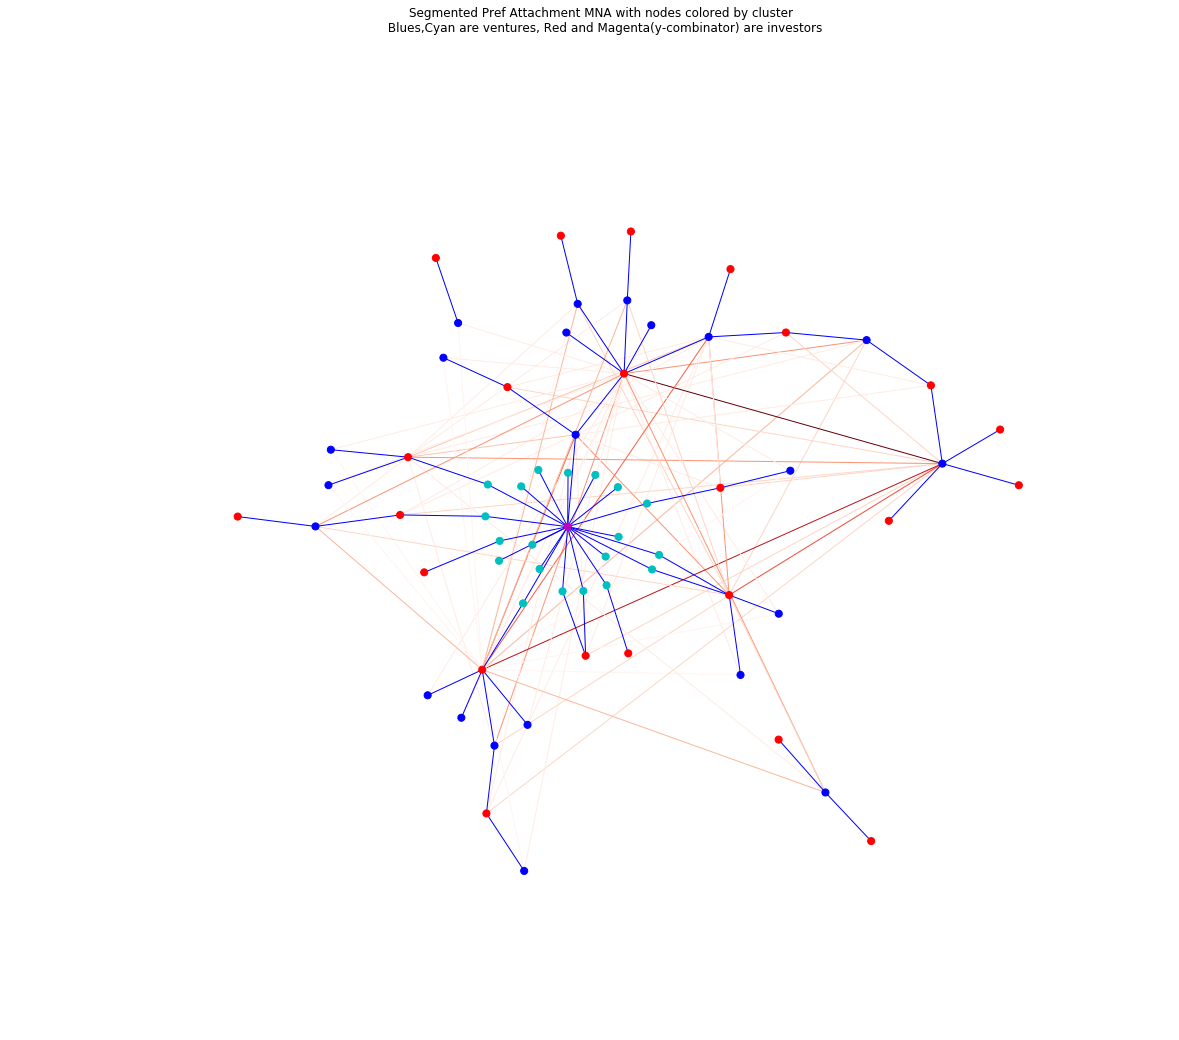

In [37]:
pos=nx.kamada_kawai_layout(G3)
figsize=(20,18)

edges_color = []
edges_label = []
edges_thresholded = []
for v,i in CalcG.edges:
    if CalcG[v][i]['type'] == "C" and CalcG[v][i]['score']['pref_spa'] > THRESHOLD :
        edges_thresholded.append((v,i))
        edges_color.append(CalcG[v][i]['score']['pref_spa'])

plt.figure(figsize=figsize)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title("Segmented Pref Attachment MNA with nodes colored by cluster \n Blues,Cyan are ventures, Red and Magenta(y-combinator) are investors")
colors = []
cluster_to_color = {'Cv_0':'b', 'Cv_1': 'c', 'Cinv_0':'r', 'Cinv_1': 'm'}
for node_name in list(CalcG.nodes()) :
    clust = cluster_dict[node_name]
    colors.append(cluster_to_color[clust])

nx.draw(CalcG, node_size=50, pos=pos, node_color=colors, linewidths = 1,
        edge_color=edges_color, edge_cmap=plt.cm.Reds, edgelist=edges_thresholded)
nx.drawing.nx_pylab.draw_networkx_edges(CalcG, pos=pos, edgelist=existing_edges, edge_color="b")
plt.show()

for v,i in candidate_edges:
    if CalcG[v][i]['score']['pref_spa'] == 1 :
        print("Nous allons illustrer pour le score maximal")
        print("v: ", v, " \t\tGamma(v) =" , G70.degree(v) )
        print("i: ", i, " \tGamma(i) =" , G70.degree(i) )
        print("Donc score_pref(v,i) = ", G70.degree(i)*G70.degree(v) , "/" , maxi_pref, " = 1 en rouge foncé sur le graphe ci-dessus")

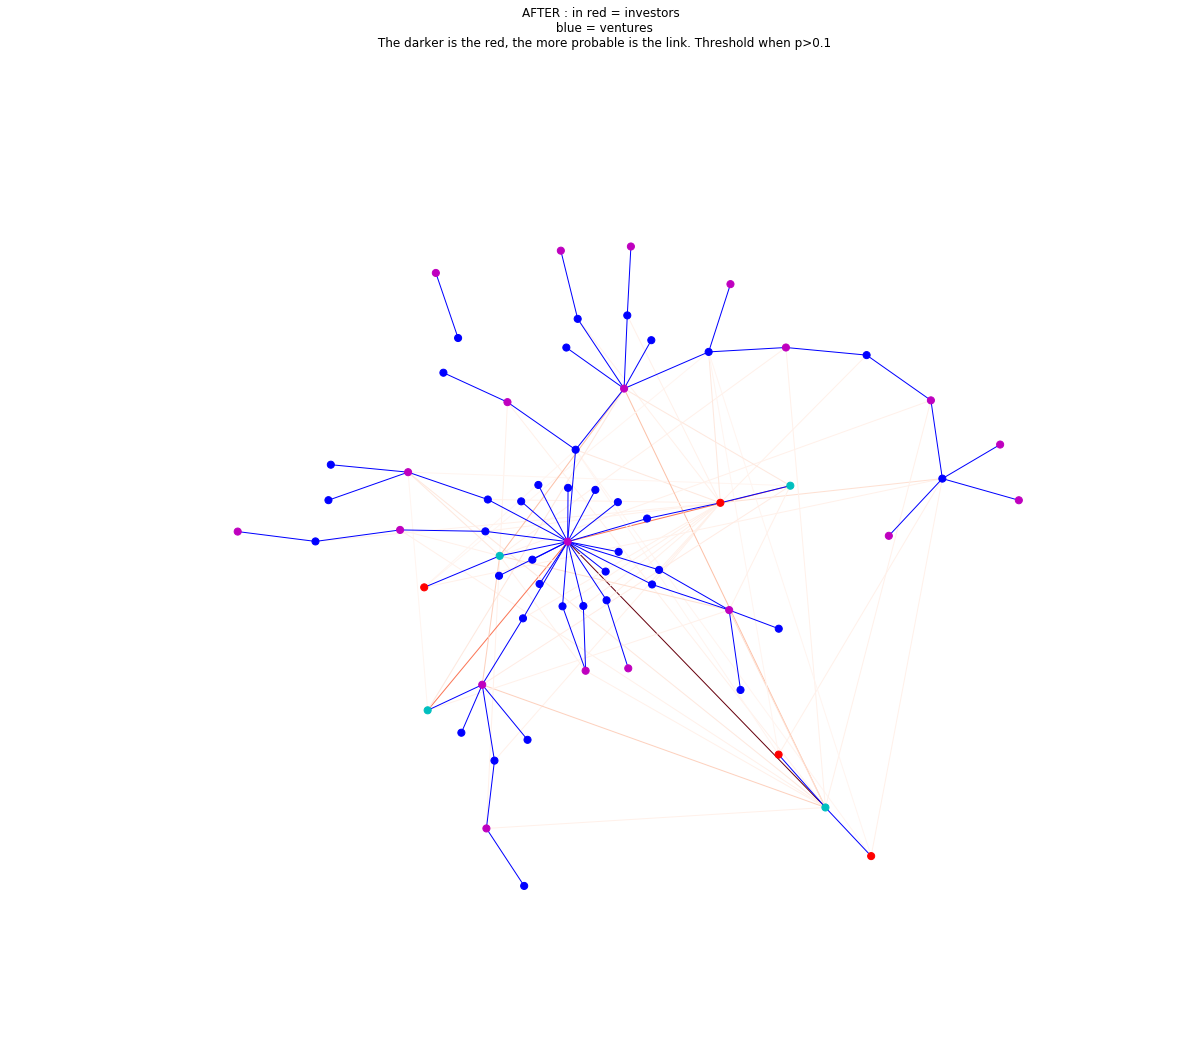

In [38]:

    
edges_color = []
edges_label = []
edges_thresholded = []
for v,i in CalcG.edges:
    if CalcG[v][i]['type'] == "C" and CalcG[v][i]['score']['pref_spa_MAI'] > THRESHOLD :
        edges_thresholded.append((v,i))
        edges_color.append(CalcG[v][i]['score']['pref_spa_MAI'])

pos=nx.kamada_kawai_layout(G3)
figsize=(20,18)

plt.figure(figsize=figsize)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title("AFTER : in red = investors \n blue = ventures\n The darker is the red, the more probable is the link. Threshold when p>0.1")
colors = []
cluster_to_color = {'Cv_0':'b', 'Cv_1': 'c', 'Cinv_0':'r', 'Cinv_1': 'm'}
for node_name in list(CalcG.nodes()) :
    clust = cluster_dict_MAI[node_name]
    colors.append(cluster_to_color[clust])
    
nx.draw(CalcG, node_size=50, pos=pos, node_color=colors, linewidths = 1,
        edge_color=edges_color, edge_cmap=plt.cm.Reds, edgelist=edges_thresholded)
nx.drawing.nx_pylab.draw_networkx_edges(CalcG, pos=pos, edgelist=existing_edges, edge_color="b")
plt.show()

for v,i in candidate_edges:
    if CalcG[v][i]['score']['pref_spa'] == 1 :
        print("Nous allons illustrer pour le score maximal")
        print("v: ", v, " \t\tGamma(v) =" , G70.degree(v) )
        print("i: ", i, " \tGamma(i) =" , G70.degree(i) )
        print("Donc score_pref_MAI(v,i) = ", G70.degree(i)*G70.degree(v) , "/" , maxi_pref, " = 1 en rouge foncé sur le graphe ci-dessus")

In [39]:
pickle.dump(CalcG, open('output_data/CalcG_small.p','wb'))